In [8]:
using CSV, DataFrames, PyPlot, Distributions, KernelDensity
PyPlot.svg(true)
using LaTeXStrings

In [9]:
data = CSV.read("./../../experimental_data/processed_data/all_experiments.csv", DataFrame);
chain = CSV.read(pwd()*"/output/NR_SpCas9_chain.csv", DataFrame);
alpha = mean(chain[:,:α])
rho = mean(chain[:,:ρ])
beta = mean(chain[:,:β])

0.15214782255379114

# Look at scaling of variance in data

In [11]:
experiments = unique(data.experiment);

In [12]:
df = data[data.experiment .== experiments[3],:];

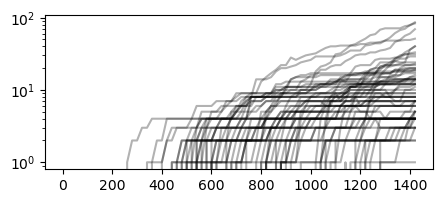

In [13]:
fig, ax = plt.subplots(figsize=(5,2))
wells = unique(df.well)
for well in wells
    dfw = df[df.well .== well,:]
    plt.semilogy(dfw[:,:time],dfw[:,:gfp],"k-",alpha=0.3)
end

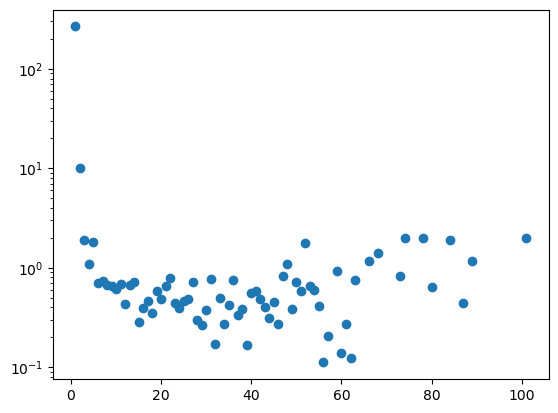

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1d349df10>

In [14]:
cv = x -> var(x)/mean(x)^2
vars = combine(groupby(df,:bf),:gfp => cv)
plt.semilogy(vars.bf,vars.gfp_function,"o")


# Comparisons to simulated data

In [15]:
function population_branching_process_discrete(p,q,tmax,well)
    M = zeros(tmax)
    B = zeros(tmax)
    R = zeros(tmax)
    M[1] = 1
    for k in 2:tmax
        breaks = rand(Binomial(2*M[k-1],p))
        repairs = rand(Binomial(B[k-1],q))
        M[k] = 2*M[k-1] - breaks
        B[k] = B[k-1] + breaks - repairs
        R[k] = 2*R[k-1] + 2*repairs
    end
    DataFrame("well"=>ones(tmax)*well,"m"=>M,"b"=>B,"r"=>R,"n"=> (M .+ B .+ R))
end




function population_branching_process_gillespie(alpha,beta,rho,tmax,well)
    M = [1]
    B = [0]
    R = [0]
    T = [0.0]
#     alpha = alpha*(1+rand(Normal(0,0.2)))
#     beta = beta*(1+rand(Normal(0,0.2)))
#     rho = rho*(1+rand(Normal(0,0.2)))
    #tmax = rand(Exponential(tmax))
    while T[end]<tmax
        rate_sum = alpha*M[end] + beta*M[end] + rho*B[end] + alpha*R[end]
        t_next = rand(Exponential(1/rate_sum))
        push!(T,T[end]+t_next)
        r = rand()
        if r < alpha*M[end]/rate_sum
            push!(M,M[end]+1)
            push!(B,B[end])
            push!(R,R[end])
        elseif r < (alpha*M[end] + beta*M[end])/rate_sum
            push!(M,M[end]-1)
            push!(B,B[end]+1)
            push!(R,R[end])   
        elseif r < (alpha*M[end] + beta*M[end] + rho*B[end] )/rate_sum
            push!(M,M[end])
            push!(B,B[end]-1)
            push!(R,R[end]+1) 
                  
        else 
            push!(M,M[end])
            push!(B,B[end])
            push!(R,R[end]+1) 
        end
                
    end
    push!(M,M[end])
    push!(B,B[end])
    push!(R,R[end]) 
    push!(T,tmax)
    DataFrame("well"=>ones(length(R))*well,"m"=>M,"b"=>B,"r"=>R,"n"=> (M .+ B .+ R),"time"=>T)
end


population_branching_process_gillespie (generic function with 1 method)

In [16]:
df = population_branching_process_gillespie(alpha,beta,rho,7,1)

,well,m,b,r,n,time
,Float64,Int64,Int64,Int64,Int64,Float64
1,1.0,1,0,0,1,0.0
2,1.0,2,0,0,2,0.794211
3,1.0,3,0,0,3,2.57362
4,1.0,2,1,0,3,3.09665
5,1.0,2,0,1,3,3.64402
6,1.0,3,0,1,4,3.65462
7,1.0,2,1,1,4,3.91375
8,1.0,2,1,2,5,3.91387
9,1.0,2,1,3,6,4.14455


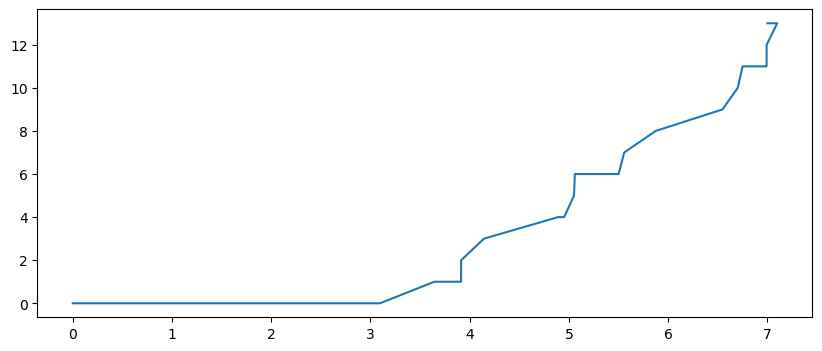

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1d31ff5b0>

In [17]:
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(df[:,:time],df[:,:r])

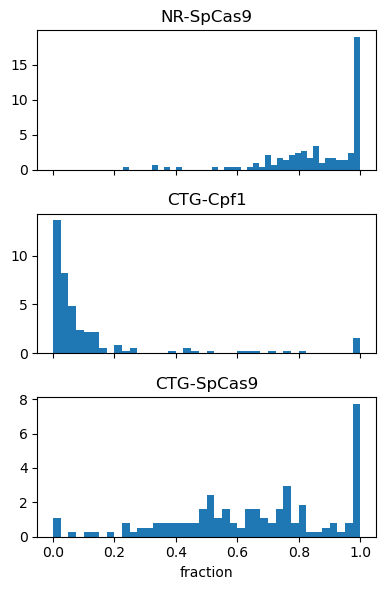

In [18]:
fig,axs = plt.subplots(figsize=(4,6),nrows=3,sharex=true)
chain = CSV.read(pwd()*"/output/NR_SpCas9_chain.csv", DataFrame);
alpha = median(chain[:,:α])
rho = mean(chain[:,:ρ])
beta = mean(chain[:,:β])

fdata = vcat([population_branching_process_gillespie(alpha,beta,rho,17,k) for k in 1:150]...);
CSV.write(pwd()*"/NR_SpCas9_stochastic.csv",fdata)

ax = axs[1]
ax.set_title("NR-SpCas9")
ax.hist(fdata[fdata.time.==17,:].r ./ fdata[fdata.time.==17,:].n,40,density=true)

chain = CSV.read(pwd()*"/output/CTG_Cpf1_chain.csv", DataFrame);
alpha = median(chain[:,:α])
rho = mean(chain[:,:ρ])
beta = mean(chain[:,:β])

fdata = vcat([population_branching_process_gillespie(alpha,beta,rho,17,k) for k in 1:150]...);
CSV.write(pwd()*"/CTG_Cpf1_stochastic.csv",fdata)

ax = axs[2]
ax.set_title("CTG-Cpf1")
ax.hist(fdata[fdata.time.==17,:].r ./ fdata[fdata.time.==17,:].n,40,density=true)

chain = CSV.read(pwd()*"/output/CTG_SpCas9_chain.csv", DataFrame);
alpha = median(chain[:,:α])
rho = mean(chain[:,:ρ])
beta = mean(chain[:,:β])


fdata = vcat([population_branching_process_gillespie(alpha,beta,rho,17,k) for k in 1:150]...);
CSV.write(pwd()*"/CTG_SpCas9_stochastic.csv",fdata)

ax = axs[3]
ax.set_title("CTG-SpCas9")
ax.hist(fdata[fdata.time.==17,:].r ./ fdata[fdata.time.==17,:].n,40,density=true)
ax.set_xlabel("fraction")

plt.tight_layout()
PyPlot.plt.savefig(pwd()*"/R_local_hist.svg",bbox_inches="tight")
PyPlot.plt.savefig(pwd()*"/R_local_hist.pdf",bbox_inches="tight")

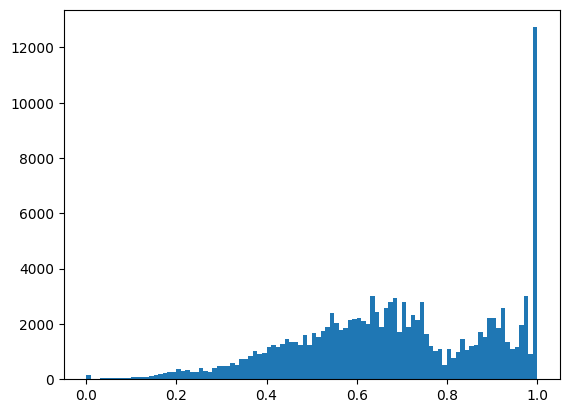

([162.0, 0.0, 10.0, 56.0, 58.0, 49.0, 57.0, 53.0, 48.0, 56.0  …  2199.0, 1841.0, 2574.0, 1351.0, 1107.0, 1175.0, 1976.0, 3024.0, 897.0, 12730.0], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99, 1.0], (PyObject <matplotlib.patches.Rectangle object at 0x7fea8060b940>, PyObject <matplotlib.patches.Rectangle object at 0x7fea806169d0>, PyObject <matplotlib.patches.Rectangle object at 0x7fea80616f70>, PyObject <matplotlib.patches.Rectangle object at 0x7fea806211c0>, PyObject <matplotlib.patches.Rectangle object at 0x7fea806213d0>, PyObject <matplotlib.patches.Rectangle object at 0x7fea806215e0>, PyObject <matplotlib.patches.Rectangle object at 0x7fea806217f0>, PyObject <matplotlib.patches.Rectangle object at 0x7fea80621a00>, PyObject <matplotlib.patches.Rectangle object at 0x7fea80621c10>, PyObject <matplotlib.patches.Rectangle object at 0x7fea80621e20>, PyObject <matplotlib.patches.Rectangle obj

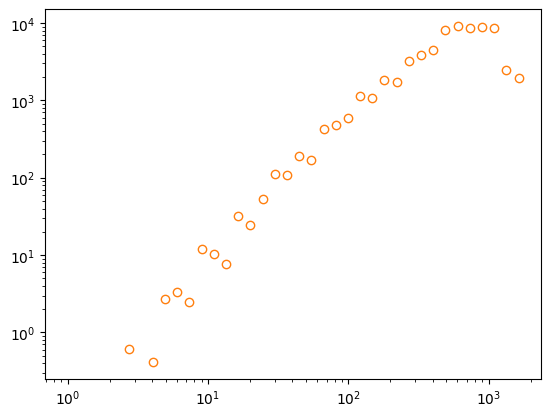

In [15]:
fdata = vcat([population_branching_process(0.3,0.1,12,k) for k in 1:200]...);
z = 0.2
bin = x -> exp(round(Int64,log(x)/(z))*z)
fdata[:,:n_round] = bin.(fdata[:,:n])
tdf = combine(groupby(fdata,:n_round),:r=>var)
plt.loglog(tdf[:,:n_round],tdf[:,:r_var],"C1o",fillstyle="none")

# z= 2
# bin = x -> round(Int64,x/(z))*z
# fdata[:,:n_round] = bin.(fdata[:,:n])
# tdf = combine(groupby(fdata,:n_round),:r=>var)
# plt.loglog(tdf[:,:n_round],tdf[:,:r_var],"C2o",fillstyle="none")

# fdata = vcat([population_branching_process(0.3,0.1,12,k) for k in 1:200]...);
# bin = x -> round(Int64,x/(z))*z
# fdata[:,:n_round] = bin.(fdata[:,:n])
# tdf = combine(groupby(fdata,:n_round),:r=>var)
# plt.loglog(tdf[:,:n_round],tdf[:,:r_var],"C2o",fillstyle="none")

# fdata = vcat([population_branching_process(0.3,0.1,12,k) for k in 1:200]...);
# bin = x -> round(Int64,x/(z))*z
# fdata[:,:n_round] = bin.(fdata[:,:n])
# tdf = combine(groupby(fdata,:n_round),:r=>var)
# plt.loglog(tdf[:,:n_round],tdf[:,:r_var],"C3o",fillstyle="none")

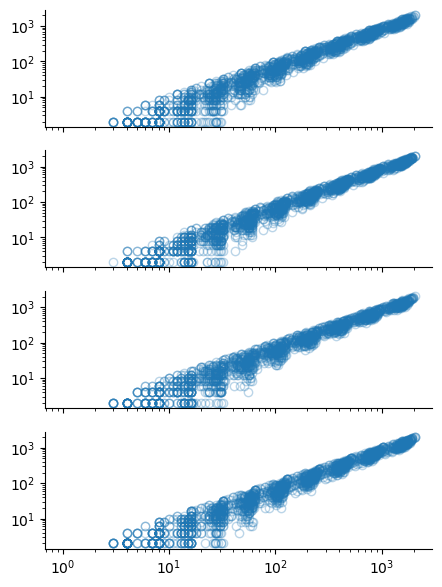

In [11]:
normal_experiments = ["NR_SpCas9","GAA_Cpf1","CGG_SpCas9","NR_Cpf1"]
fig,axs = plt.subplots(figsize=(5,7),nrows = length(normal_experiments),sharex=true,sharey=false)
j = 1
for experiment in normal_experiments
    ax = axs[j]
    #df = data[data.experiment .==experiment,:]
    df = vcat([population_branching_process(0.2,0.5,12,k) for k in 1:200]...);
    ax.loglog(df[:,:n],df[:,:r],"o",fillstyle="none",alpha=0.3)
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)

    j+=1

end

In [32]:
ps = []
lnthetas = []
for (root, dirs, files) in walkdir(pwd()*"/output")
    for f in files
        if occursin("chain.csv",f) 
            println(f)
            df = CSV.read(pwd()*"/output/"*f,DataFrame)
            p = mean(1 .-2 .^(-df[:,:beta] ./df[:,:alpha]))
            q = mean(1 .-2 .^(-df[:,:rho] ./df[:,:alpha]))
            
            # get experiment name
            push!(ps,DataFrame([p q SubString(f,1:(length(f)-10))],[:p,:q,:experiment]))
        end
        #path = pwd()*"/output/"*dir
        
#         try 
#             df = CSV.read(path*"/pred_df.csv",DataFrame)
#             push!(dfs,df)
#         catch e
#             println(e)
#         end 
        
    end
end

CGG_Cpf1_chain.csv
CGG_SpCas9_chain.csv
CTG_Cpf1_chain.csv
CTG_SpCas9_chain.csv
GAA_Cpf1_chain.csv
GAA_SpCas9_chain.csv
NR-1_Cpf1_chain.csv
NR-2_Cpf1_chain.csv
NR_Cpf1_chain.csv
NR_SpCas9_chain.csv


In [33]:
df_p = vcat(ps...)

,p,q,experiment
,Any,Any,Any
1,0.119471,0.395088,CGG_Cpf1
2,0.228095,0.487362,CGG_SpCas9
3,0.0525411,0.17813,CTG_Cpf1
4,0.08066,0.662317,CTG_SpCas9
5,0.11163,0.17246,GAA_Cpf1
6,0.140665,0.46405,GAA_SpCas9
7,0.433707,0.483402,NR-1_Cpf1
8,0.2592,0.331991,NR-2_Cpf1
9,0.42127,0.348377,NR_Cpf1


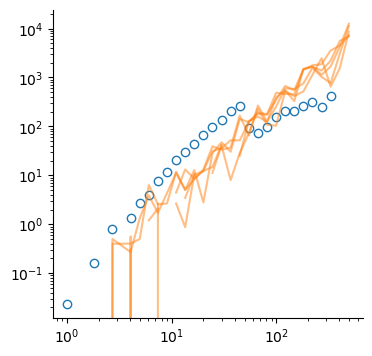

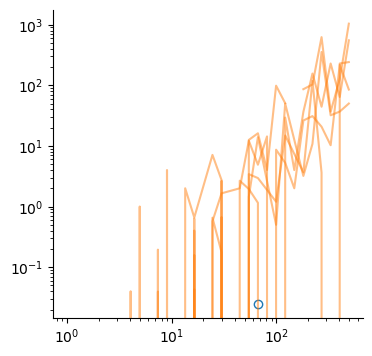

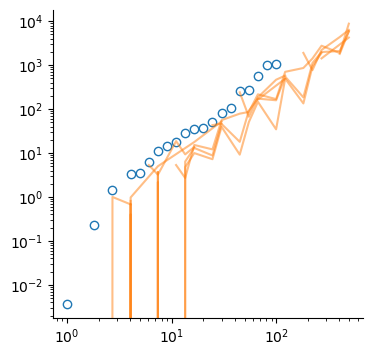

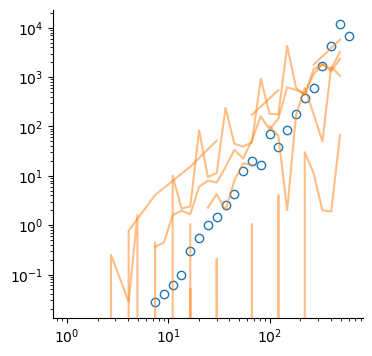

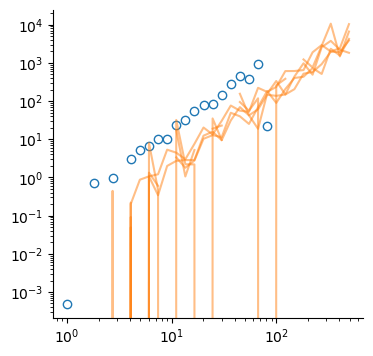

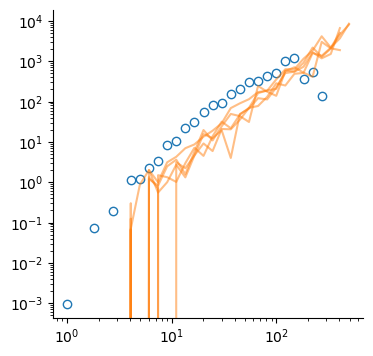

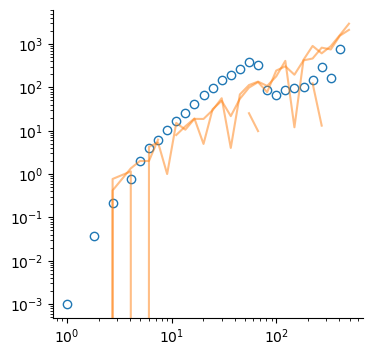

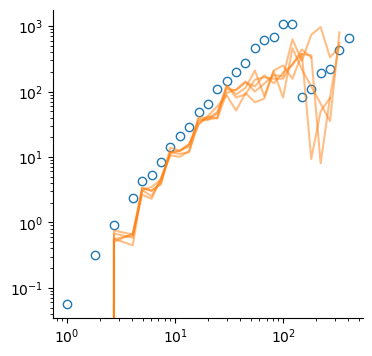

In [69]:
#normal_experiments = ["NR_SpCas9","GAA_Cpf1","CGG_SpCas9","NR_Cpf1"]
experiments = unique(data.experiment)

j = 1
for experiment in experiments
    df = data[data.experiment .==experiment,:]
    z = 0.2
    bin = x -> exp(round(Int64,log(x)/(z))*z)
    df[:,:bf_round] = bin.(df[:,:bf])
    tdf = sort(combine(groupby(df,:bf_round),:gfp=>var),:bf_round)
    CSV.write(pwd()*"/output/"*experiment*"_varGN_data.csv",tdf)
    
    fig,ax = plt.subplots(figsize=(4,4))
    ax.loglog(tdf[:,:bf_round],tdf[:,:gfp_var],"o",fillstyle="none",label="data")
    
    
    chain = CSV.read(pwd()*"/output/"*experiment*"_chain.csv",DataFrame)
    ps = 1 .-2 .^(-chain[:,:beta] ./chain[:,:alpha])
    qs = 1 .-2 .^(-chain[:,:rho] ./chain[:,:alpha])
    for i in 1:5
        p = ps[i]
        q = qs[i]
        fdata = vcat([population_branching_process(p,q,10,k) for k in 1:length(unique(df.well))]...);
        z = 0.2
        fdata[:,:n_round] = bin.(fdata[:,:n])
        tdf = sort(combine(groupby(fdata,:n_round),:r=>var),:n_round)
        
        
        ax.loglog(tdf[:,:n_round],tdf[:,:r_var],"C1-",fillstyle="none",alpha=0.5,label="posterior simulations")
        CSV.write(pwd()*"/output/"*experiment*"_varGN_sims_$i.csv",tdf)
    end
    
    
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
#     ax.set_title(experiment)
#     ax.set_xlabel(L"$N$")
#     ax.set_ylabel(L"${\rm var}(G|N)$")
#     ax.legend(frameon=false)
    plt.savefig(pwd()*"/output/"*experiment*"_varGN_data_vs_posterior_normal.svg")
    
    j+=1

end


# df = data[data.experiment .== experiments[7],:]
# bin = x -> round(Int64,x/(z))*z
# df[:,:bf_round] = bin.(df[:,:bf])
# tdf = combine(groupby(df,:bf_round),:gfp=>var)
# plt.loglog(tdf[:,:bf_round],tdf[:,:gfp_var],"o",fillstyle="none")


In [32]:
normal_experiments[1]

"NR_SpCas9"